Write your own gradient boosting algorithm for logistic regression using parametric learners.
1. Run the algorithm on a data set of your choosing and compare the results to GLM.
2. Repeat your analysis of part 1 but where the boosting algorithm is modified so that the design matrix includes an intercept term which is treated just like the other covariates (dimension is p + 1). Thus the line-search is modified to

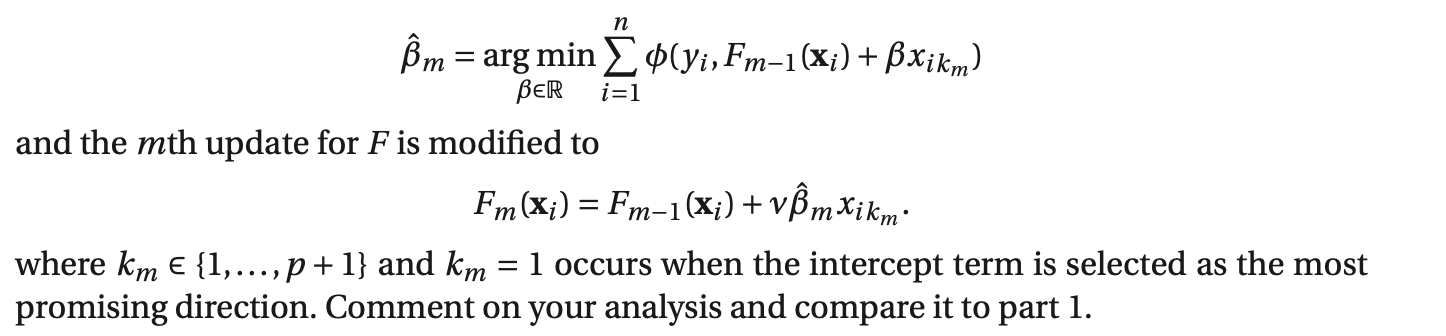

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import Optional, Tuple, List

# sigmoid utilities
def sigmoid(t: np.ndarray) -> np.ndarray:
    # numerically safe σ
    out = np.empty_like(t, dtype=float)
    pos = t >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-t[pos]))
    exp_t = np.exp(t[~pos])
    out[~pos] = exp_t / (1.0 + exp_t)
    return out

def logloss_from_eta(eta: np.ndarray, y: np.ndarray) -> float:
    # L = sum log(1+exp(eta)) - y*eta
    # stable log(1+exp(eta))
    a = np.maximum(eta, 0.0)
    return float(np.sum(a + np.log1p(np.exp(-np.abs(eta))) - y * eta))

# 1-D Newton line search along a direction z
def line_search_beta(eta: np.ndarray,
                     y: np.ndarray,
                     z: np.ndarray,
                     max_iter: int = 50,
                     tol: float = 1e-10) -> Tuple[float, float]:
    """
    Minimize L(β) = sum log(1+exp(eta + β z)) - y*(eta + β z)
    Returns (beta_hat, loss_at_beta_hat)
    """
    beta = 0.0
    L_prev = np.inf

    for _ in range(max_iter):
        t = eta + beta * z
        p = sigmoid(t)
        # gradient and Hessian in closed form
        g = np.sum(z * (p - y))
        w = p * (1.0 - p)
        h = np.sum((z * z) * w)

        if h <= 1e-16:  # nearly flat; fall back to tiny step
            step = -np.sign(g) * 1e-6
        else:
            step = -g / h

        # backtracking to ensure descent
        new_beta = beta + step
        L_new = logloss_from_eta(eta + new_beta * z, y)
        if L_new <= L_prev - 1e-12:
            beta, L_prev = new_beta, L_new
        else:
            # halve step until improvement (or give up)
            shrink = 0
            improved = False
            while shrink < 25:
                step *= 0.5
                new_beta = beta + step
                L_new = logloss_from_eta(eta + new_beta * z, y)
                if L_new < L_prev - 1e-12:
                    beta, L_prev = new_beta, L_new
                    improved = True
                    break
                shrink += 1
            if not improved:
                break  # cannot improve further

        # first-order stop when gradient tiny
        if abs(g) < tol:
            break

    return float(beta), float(L_prev)

# The booster
@dataclass
class ParametricGBLogit:
    n_rounds: int = 200
    learning_rate: float = 0.1
    include_intercept_direction: bool = False
    standardize: bool = True
    random_state: int = 0

    # learned state
    mu_: Optional[np.ndarray] = None    # feature means (for standardization)
    sd_: Optional[np.ndarray] = None    # feature stds
    F0_: Optional[float] = None         # initial offset (log-odds)
    betas_: Optional[List[float]] = None
    coords_: Optional[List[int]] = None # chosen feature indices (0 = intercept)
    loss_path_: Optional[List[float]] = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        rng = np.random.RandomState(self.random_state)
        n, p = X.shape
        y = y.astype(float).reshape(-1)

        # standardize features (no intercept column)
        if self.standardize:
            mu = X.mean(axis=0)
            sd = X.std(axis=0, ddof=0)
            sd[sd == 0.0] = 1.0
            Xs = (X - mu) / sd
            self.mu_, self.sd_ = mu, sd
        else:
            Xs = X.copy()
            self.mu_ = np.zeros(p)
            self.sd_ = np.ones(p)

        # init offset = log-odds of prevalence
        pbar = np.clip(y.mean(), 1e-8, 1 - 1e-8)
        F = np.full(n, np.log(pbar / (1 - pbar)), dtype=float)
        self.F0_ = float(F[0])

        self.betas_, self.coords_, self.loss_path_ = [], [], []
        current_loss = logloss_from_eta(F, y)
        self.loss_path_.append(current_loss)

        # coordinate-wise boosting
        for m in range(self.n_rounds):
            best_k, best_beta, best_loss = None, None, np.inf

            # iterate over candidate directions
            start_k = 0 if self.include_intercept_direction else 1
            for k in range(start_k, p + 1):
                if k == 0:
                    z = np.ones(n)  # intercept direction
                else:
                    z = Xs[:, k - 1]  # feature k-1 (since 0 reserved for intercept)

                beta_k, loss_k = line_search_beta(F, y, z)
                if loss_k < best_loss:
                    best_k, best_beta, best_loss = k, beta_k, loss_k

            # apply shrinkage
            F = F + self.learning_rate * best_beta * (np.ones(n) if best_k == 0 else Xs[:, best_k - 1])

            self.betas_.append(self.learning_rate * best_beta)
            self.coords_.append(best_k)
            self.loss_path_.append(logloss_from_eta(F, y))

        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        # project new data using learned path
        n, p = X.shape
        if self.mu_ is None:
            raise RuntimeError("Model is not fit.")
        Xs = (X - self.mu_) / self.sd_
        F = np.full(n, self.F0_, dtype=float)
        for beta, k in zip(self.betas_, self.coords_):
            if k == 0:
                F += beta
            else:
                F += beta * Xs[:, k - 1]
        return F

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        eta = self.decision_function(X)
        p1 = sigmoid(eta)
        return np.c_[1.0 - p1, p1]

    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

In [ ]:
# load a binary dataset (Breast Cancer from scikit)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

X, y = load_breast_cancer(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Part 1: boosting WITHOUT intercept direction
gb1 = ParametricGBLogit(n_rounds=300, learning_rate=0.05, include_intercept_direction=False).fit(X_tr, y_tr)
p1 = gb1.predict_proba(X_te)[:, 1]
print("GB (no intercept)  logloss:", log_loss(y_te, p1),
      "AUC:", roc_auc_score(y_te, p1), "ACC:", accuracy_score(y_te, p1 >= 0.5))

# Part 2: boosting WITH intercept direction
gb2 = ParametricGBLogit(n_rounds=300, learning_rate=0.05, include_intercept_direction=True).fit(X_tr, y_tr)
p2 = gb2.predict_proba(X_te)[:, 1]
print("GB (+ intercept)   logloss:", log_loss(y_te, p2),
      "AUC:", roc_auc_score(y_te, p2), "ACC:", accuracy_score(y_te, p2 >= 0.5))

# Baseline GLM (full logistic regression)
glm = LogisticRegression(max_iter=2000, solver="lbfgs")
glm.fit(X_tr, y_tr)
pg = glm.predict_proba(X_te)[:, 1]
print("GLM (scikit)       logloss:", log_loss(y_te, pg),
      "AUC:", roc_auc_score(y_te, pg), "ACC:", accuracy_score(y_te, pg >= 0.5))

# Inspect which coordinates were chosen most often
import collections
print("Top selected coordinates (0 means intercept):",
      collections.Counter(gb2.coords_).most_common(10))

GB (no intercept)  logloss: 0.0721808406212449 AUC: 0.9979035639412999 ACC: 0.972027972027972
GB (+ intercept)   logloss: 0.0722039160984484 AUC: 0.9979035639412999 ACC: 0.972027972027972
GLM (scikit)       logloss: 0.08789524972921794 AUC: 0.9960167714884697 ACC: 0.958041958041958
Top selected coordinates (0 means intercept): [(22, 52), (11, 45), (28, 33), (21, 28), (16, 27), (25, 26), (29, 22), (14, 19), (2, 14), (23, 9)]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# trying to fix the warning by scikit

glm = LogisticRegression(max_iter=5000, solver="lbfgs")
glm.fit(X_tr, y_tr)
pg = glm.predict_proba(X_te)[:, 1]
print("GLM (scikit)       logloss:", log_loss(y_te, pg),
      "AUC:", roc_auc_score(y_te, pg), "ACC:", accuracy_score(y_te, pg >= 0.5))

GLM (scikit)       logloss: 0.08723442752056412 AUC: 0.9955974842767296 ACC: 0.958041958041958


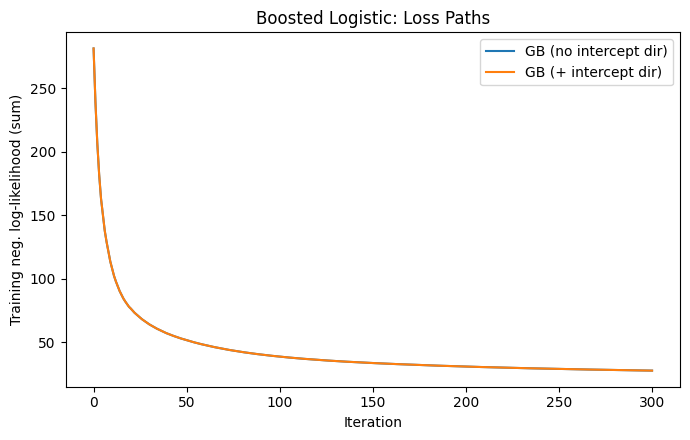

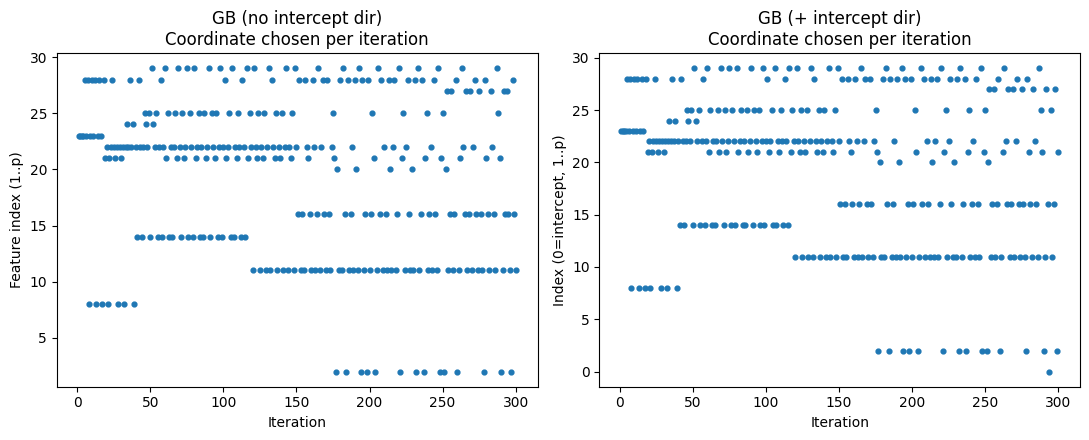

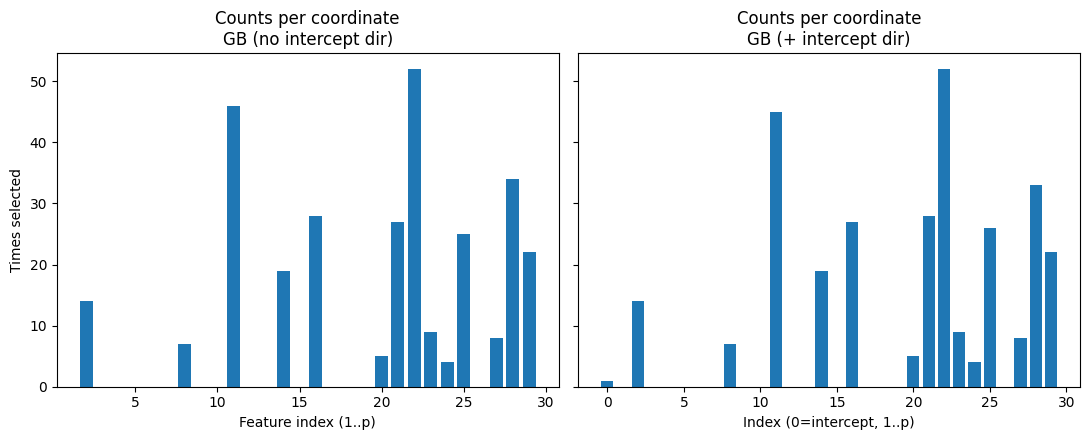

                   model  train_logloss  test_logloss  train_acc  test_acc
0  GB (no intercept dir)       0.065336      0.072181   0.983568  0.972028
1   GB (+ intercept dir)       0.065332      0.072204   0.983568  0.972028
2         GLM (logistic)       0.089618      0.087895   0.960094  0.958042


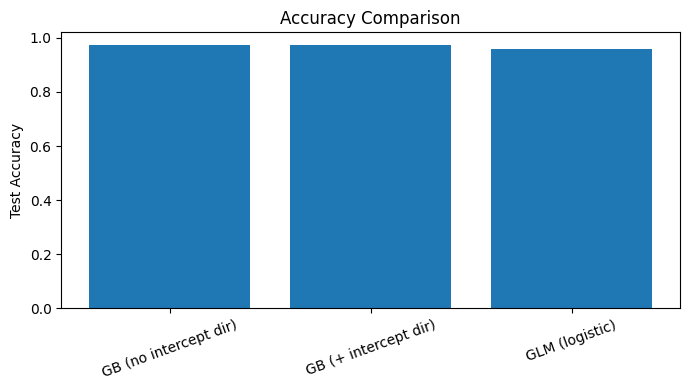

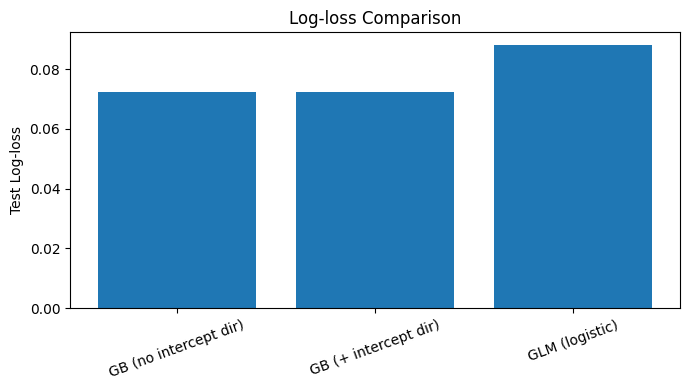

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ============= 1) Plot gb1.loss_path_ vs gb2.loss_path_ =============
iters1 = np.arange(len(gb1.loss_path_))  # includes iteration 0 (init)
iters2 = np.arange(len(gb2.loss_path_))

plt.figure(figsize=(7,4.5))
plt.plot(iters1, gb1.loss_path_, label="GB (no intercept dir)")
plt.plot(iters2, gb2.loss_path_, label="GB (+ intercept dir)")
plt.xlabel("Iteration")
plt.ylabel("Training neg. log-likelihood (sum)")
plt.title("Boosted Logistic: Loss Paths")
plt.legend()
plt.tight_layout()
plt.show()

# ======= 2) Coordinate-descent path (which coordinate picked when) =======
# Scatter: x = iteration index, y = coordinate index chosen
fig, axes = plt.subplots(1, 2, figsize=(11,4.5), sharex=True)

axes[0].scatter(np.arange(1, len(gb1.coords_)+1), gb1.coords_, s=12)
axes[0].set_title("GB (no intercept dir)\nCoordinate chosen per iteration")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Feature index (1..p)")

axes[1].scatter(np.arange(1, len(gb2.coords_)+1), gb2.coords_, s=12)
axes[1].set_title("GB (+ intercept dir)\nCoordinate chosen per iteration")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Index (0=intercept, 1..p)")

plt.tight_layout()
plt.show()

# Also: bar chart of how many times each coordinate was selected
cnt1 = Counter(gb1.coords_)  # 1..p
cnt2 = Counter(gb2.coords_)  # 0..p, with 0 = intercept

fig, axes = plt.subplots(1, 2, figsize=(11,4.5), sharey=True)
axes[0].bar(list(cnt1.keys()), list(cnt1.values()))
axes[0].set_title("Counts per coordinate\nGB (no intercept dir)")
axes[0].set_xlabel("Feature index (1..p)")
axes[0].set_ylabel("Times selected")

axes[1].bar(list(cnt2.keys()), list(cnt2.values()))
axes[1].set_title("Counts per coordinate\nGB (+ intercept dir)")
axes[1].set_xlabel("Index (0=intercept, 1..p)")

plt.tight_layout()
plt.show()

# Note: GLM does not have a coordinate path; if desired, compare coefficient magnitudes:
# plt.figure(figsize=(7,4)); plt.stem(np.r_[glm.intercept_, glm.coef_.ravel()]); plt.show()

# ======= 3) Accuracy & log-loss comparison for all 3 models =======
# Boosters
p1_tr = gb1.predict_proba(X_tr)[:, 1]
p1_te = gb1.predict_proba(X_te)[:, 1]

p2_tr = gb2.predict_proba(X_tr)[:, 1]
p2_te = gb2.predict_proba(X_te)[:, 1]

# GLM
pg_tr = glm.predict_proba(X_tr)[:, 1]
pg_te = glm.predict_proba(X_te)[:, 1]

def _metrics_row(name, y_tr, p_tr, y_te, p_te):
    return {
        "model": name,
        "train_logloss": log_loss(y_tr, p_tr),
        "test_logloss":  log_loss(y_te, p_te),
        "train_acc": accuracy_score(y_tr, (p_tr >= 0.5).astype(int)),
        "test_acc":  accuracy_score(y_te, (p_te >= 0.5).astype(int)),
    }

rows = []
rows.append(_metrics_row("GB (no intercept dir)", y_tr, p1_tr, y_te, p1_te))
rows.append(_metrics_row("GB (+ intercept dir)", y_tr, p2_tr, y_te, p2_te))
rows.append(_metrics_row("GLM (logistic)",        y_tr, pg_tr, y_te, pg_te))

# pretty print table
try:
    import pandas as pd
    df_metrics = pd.DataFrame(rows)
    print(df_metrics)
except Exception:
    for r in rows:
        print(r)

# (Optional) bar plots of test accuracy and test log-loss
plt.figure(figsize=(7,4))
names = [r["model"] for r in rows]
test_acc = [r["test_acc"] for r in rows]
plt.bar(names, test_acc)
plt.xticks(rotation=20)
plt.ylabel("Test Accuracy")
plt.title("Accuracy Comparison")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
test_ll = [r["test_logloss"] for r in rows]
plt.bar(names, test_ll)
plt.xticks(rotation=20)
plt.ylabel("Test Log-loss")
plt.title("Log-loss Comparison")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
pr_auc_trap = auc(*precision_recall_curve(y_te, pg)[1::-1])
pr_auc_trap

np.float64(0.9974944805643409)

Obervations:
1. Both boosted variants beat generalized linear model on log-loss (~0.072 vs ~0.088) and accuracy (~0.972 vs ~0.958).
2. AUROC is extremely high for all, with a very small edge for boosting over LR (~0.998 vs ~0.996).
3. The curves for “with” and “without intercept-direction” are almost same.
	•	Reason: features were standardized, so the optimal intercept is approximately near zero and does not need repeated adjustment; the base rate initialization already captures most of the offset. The intercept (index 0) is selected rarely, most improvement comes from a handful of predictors. Hence adding an intercept search does not brings much improvement on this dataset.
4. A small subset of features is selected many times (e.g., 22, 11, 28, 21 … with high counts) which is classic boosting behavior. The algorithm reuses the same directions to grow coefficients gradually (shrinkage) (hence performing sparse, L1-like regularization).
5. The two variants choose mostly the same coordinates in similar orders, so the intercept search does not change the path here.

So stage wise shrinkage and repeatedly using a few strong coordinates give better calibrated probabilities than a single global fit (in case of LR).
Note : The ‘intercept as a direction’ helps more: 
a) When we have Strong class imbalance
b) non-centered features
c) starting with F_0=0 and not centering
d) when the baseline drifts during training (e.g., with sample weights). In such cases, we typically see early, repeated picks of coordinate 0 and a faster loss drop.
With small learning rate and enough rounds, this approaches coordinate descent logistic regression. Adding the intercept direction mostly improves calibration and speed of convergence versus forcing features to fake the offset.

The goal of this exercise is to use gradient boosting with parametric learners to
predict customer churn based on various customer features.
1. Find a dataset containing information about customers and whether they have churned. One
suggestion is the Telco Customer Churn dataset.
2. Split the dataset into training and testing sets.
3. Implement gradient boosting using parametric learners to predict customer churn.
4. Train the model on the training set and evaluate its performance on the testing set using
metrics such as accuracy, precision, recall, and F1-score.

In [ ]:
# Exercise 12.9 — Gradient Boosting with Parametric Learners
# Dataset: IBM Telco Customer Churn (OpenML id=42178)

import numpy as np
import pandas as pd
from collections import Counter

# sklearn utilities for data & metrics
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

telco = fetch_openml(data_id=42178, as_frame=True)
df = telco.frame.copy()


df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

y = df["Churn"].values
X = df.drop(columns=["Churn"])

# split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


cat_cols = X_tr.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_tr.select_dtypes(exclude=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]), cat_cols),
    ],
    remainder="drop",
)

# fit transform to numeric arrays (reuse-friendly for the booster)
Xtr_mat = preprocess.fit_transform(X_tr)
Xte_mat = preprocess.transform(X_te)

# Train booster (same hyperparams)
gb = ParametricGBLogit(
    n_rounds=400,
    learning_rate=0.05,
    include_intercept_direction=True,  # reuse Part-2 idea
    standardize=True,
    random_state=42
).fit(Xtr_mat, y_tr)

# Evaluate metrics (as requested)
yhat = gb.predict(Xte_mat)
acc  = accuracy_score(y_te, yhat)
prec = precision_score(y_te, yhat, zero_division=0)
rec  = recall_score(y_te, yhat,    zero_division=0)
f1   = f1_score(y_te, yhat,       zero_division=0)

print("Exercise 12.9 — Parametric GB on Telco Churn (test set)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# (Optional) Quick sanity: coordinate usage (0 = intercept)
# from collections import Counter
# print(Counter(gb.coords_).most_common(10))

Exercise 12.9 — Parametric GB on Telco Churn (test set)
Accuracy : 0.7984
Precision: 0.6474
Recall   : 0.5268
F1-score : 0.5809


In [ ]:
# y.count_values()
unique_values, counts = np.unique(y, return_counts=True)
unique_values, counts

(array([0, 1]), array([5174, 1869]))

In [ ]:
X.shape

(7043, 19)

In [ ]:
Xtr_mat.shape

(5282, 45)

In [ ]:
pr_auc_trap = auc(*precision_recall_curve(y_te, yhat)[1::-1])
pr_auc_trap

np.float64(0.6498159465581353)